In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from matplotlib import offsetbox
import pickle
from math import *

from scipy import ndimage
from skimage import feature
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage import exposure
from skimage import filters
from skimage.transform import rescale, resize, downscale_local_mean

from sklearn import manifold
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
#A little function to plot the confusion matrix using matplotlb
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    print('Confusion matrix')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [3]:
def sigmoid(x):
  return 1 / (1 + exp(-x))

In [4]:
def center(img):
    x,y = ndimage.center_of_mass(img)
    x -= img.shape[0]/2;
    y -= img.shape[1]/2;
    x = np.round(x)
    y = np.round(y)
    k = 10
    while(x!=0 or y!=0):
        k-=1
        if(np.isnan(x) or np.isnan(y)):
            return img
        if k < 0:
            break
        newimg = np.zeros_like(img)
        for i in range(0,64):
            if i-x < 0:
                continue
            if i-x > 63:
                continue
            for j in range(0,64):
                if j-y < 0: 
                    continue
                if j-y > 63:
                    continue
                J = int(j-y)
                I = int(i-x)
                newimg[I][J] = img[i][j]
        x,y = ndimage.measurements.center_of_mass(newimg)
        x-=32
        y-=32
        x = np.round(x)
        y = np.round(y)
        img = newimg
    return img

In [5]:
chess_data = pd.read_csv("dataGray28.csv",sep=',')
print(chess_data.shape)
chess_data_noEmpty = chess_data[chess_data.type!='empty'];
chess_labels_isEmpty = chess_data.type.map(dict(empty=1, pawn=0, rook=0, knight=0, bishop=0, queen=0, king=0))

chess_features = chess_data.drop(['type','color'],axis=1)
chess_features /= 255

chess_list = chess_features.values
chess_list = chess_list.reshape(chess_list.shape[0],int(sqrt(chess_list.shape[1])),int(sqrt(chess_list.shape[1])))
chess_list_extended = np.zeros((chess_list.shape[0],chess_list.shape[1]*2,chess_list.shape[2]))

images = np.zeros_like(chess_list)

for pos,item in enumerate(chess_list):
    #chess_list_extended[pos] = prewitt(item)>(0.4/(sum(sum(item))/3000))
    item = sobel(item)
    images[pos][3:24,3:24] = item[3:24,3:24]
    k = 1.5
    l = 0.001
    r = 3
    while(abs(r-l)>0.1):
        k = (l+r)/2.0
        img = feature.canny(images[pos],k)
        s = sum(sum(img))
        if(s>256):
            l = k
        else:
            r = k
    images[pos] = feature.canny(images[pos],l)
    images[pos] = convex_hull_image(closing(images[pos]) == 1)
    #images[pos] = center(images[pos])
    
    k = 0.04
    l = 0.04
    r = 0.2
    while(abs(r-l)>0.01):
        k = (l+r)/2.0
        img = item>k
        s = sum(sum(img))
        if(s<2000):
            r = k
        else:
            l = k
    chess_list_extended[pos] = list(images[pos]) + list(item>l)

images_small = np.zeros((images.shape[0],int(images.shape[1] / 4), int(images.shape[2] / 4)))
for pos,item in enumerate(images):
    images_small[pos] = resize(images[pos], (images[pos].shape[0] / 4, images[pos].shape[1] / 4), anti_aliasing=True)
    images_small[pos] = np.rot90(images_small[pos],-1)
chess_features = pd.DataFrame(chess_list_extended.reshape(chess_list_extended.shape[0],chess_list_extended.shape[1]*chess_list_extended.shape[2]))
#chess_features = pd.DataFrame(chess_list.reshape(chess_list.shape[0],chess_list.shape[1]*chess_list.shape[2]))

(2142, 786)


c:\users\hidelord\appdata\local\programs\python\python36\lib\site-packages\skimage\morphology\convex_hull.py:53: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  "Returning empty image", UserWarning)
c:\users\hidelord\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [6]:
chess_labels = chess_data.iloc[:,-2:]

chess_features_train,chess_features_test,chess_labels_train,chess_labels_test = train_test_split(
    chess_features, chess_labels, train_size=0.60, test_size=0.40, stratify=chess_labels.type,random_state=4321)
#deviding the dataset into training and testing

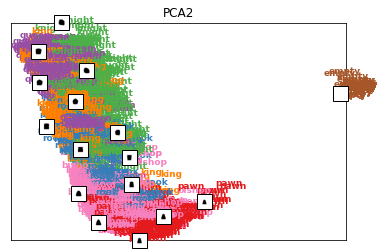

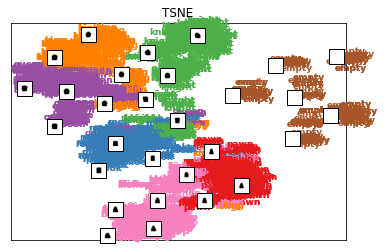

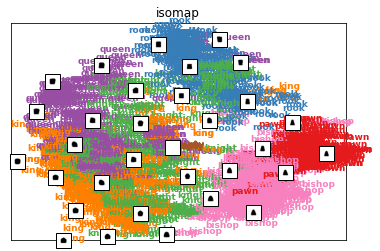

In [7]:
def plot_embedding(X, title="Lolz"):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    dc = {'pawn':1,'rook':2,'knight':3,'queen':4,'king':5,'bishop':8,'empty':7,}
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(chess_labels.type[i]),
                 color=plt.cm.Set1(dc[str(chess_labels.type[i])] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 0.015:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images_small[i], cmap=plt.cm.gray_r), X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
pca = PCA(n_components=2,whiten=True).fit(chess_features)
chess_features_pca2 = pca.transform(chess_features)
plot_embedding(chess_features_pca2,"PCA2")

tsne = manifold.TSNE(n_components=2, init='pca',perplexity=30)
chess_features_TSNE = tsne.fit_transform(chess_features)
plot_embedding(chess_features_TSNE,"TSNE")

chess_features_isomap = manifold.Isomap(20, n_components=2).fit_transform(chess_features)
plot_embedding(chess_features_isomap,"isomap")

plt.show()

In [8]:
isomap = manifold.Isomap(n_neighbors=10, n_components=10).fit(chess_features)
chess_features_train_iso50 = isomap.transform(chess_features_train)
chess_features_test_iso50 = isomap.transform(chess_features_test)

In [9]:
pca = PCA(n_components=100,whiten=True).fit(chess_features)
chess_features_train_pca100 = pca.transform(chess_features_train) 
chess_features_test_pca100 = pca.transform(chess_features_test)
#joblib.dump(pca,"pca.joblib")

pca = PCA(n_components=50,whiten=False).fit(chess_features)
chess_features_train_pca50 = pca.transform(chess_features_train)
chess_features_test_pca50 = pca.transform(chess_features_test)
joblib.dump(pca,"pca.joblib")

['pca.joblib']

Confusion matrix
[[118   0   0   0   5   0   0]
 [  0 122   0   0   0   0   0]
 [  3   0 112   0   3   4   1]
 [  0   0   0 121   0   0   1]
 [  1   0   0   0 121   0   0]
 [  0   0   0   1   0 119   3]
 [  0   0   0   1   0   0 121]]
0.9665369649805448
0.9731621936989499


c:\users\hidelord\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma=9.052631578947369e-06,
   kernel='rbf', max_iter=-1, nu=0.14210526315789473, probability=False,
   random_state=None, shrinking=True, tol=0.001, verbose=False)

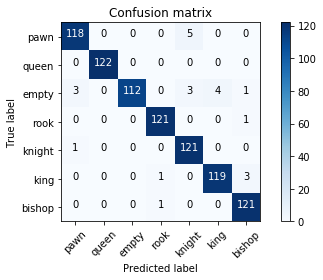

In [9]:
def classifySVM(X,Y, x,y):
    param_grid = {'nu': np.linspace(0.1,0.2,20,endpoint=True),#40
              'gamma': np.linspace(0.000001,0.00001,20,endpoint=True),#40
                 'kernel': ['rbf'],}
    classifier = GridSearchCV(estimator=NuSVC(), param_grid=param_grid, cv=5)
    classifier.fit(X, Y)
    plot_confusion_matrix(confusion_matrix(y, classifier.best_estimator_.predict(x)),y.unique())
    print(classifier.best_score_)
    print(classifier.best_estimator_.score(x, y))
    return classifier.best_estimator_
clf_figuresSVC = classifySVM(chess_features_train_pca50,chess_labels_train.type,chess_features_test_pca50,chess_labels_test.type)
clf_figuresSVC

In [10]:
joblib.dump(clf_figuresSVC,"NuSVC_Figure_Recognizer.joblib")

['NuSVC_Figure_Recognizer.joblib']

Confusion matrix
[[121   0   0   0   2   0   0]
 [  0 122   0   0   0   0   0]
 [  1   0 116   0   3   3   0]
 [  1   0   0 121   0   0   0]
 [  2   0   0   0 120   0   0]
 [  0   0   0   0   0 120   3]
 [  0   0   0   1   0   1 120]]
0.9642023346303502
0.9801633605600933


LogisticRegression(C=0.07612244897959183, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='auto', n_jobs=None, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

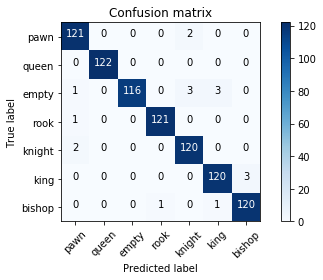

In [13]:
def classifyLogReg(X,Y, x,y):
    param_grid = {'C': np.linspace(0.01,0.1,50),
              'penalty': ['l2'], }
    classifier = GridSearchCV(LogisticRegression(multi_class='auto', solver = 'newton-cg'), param_grid, cv=5)
    classifier.fit(X, Y)
    plot_confusion_matrix(confusion_matrix(y, classifier.best_estimator_.predict(x)),y.unique())
    print(classifier.best_score_)
    print(classifier.best_estimator_.score(x, y))
    return classifier.best_estimator_
clf_figures_logReg = classifyLogReg(chess_features_train_pca50,chess_labels_train.type,chess_features_test_pca50,chess_labels_test.type)
clf_figures_logReg

Logistic regression also does incredibly well but not on the same level as the above one.

In [12]:
joblib.dump(clf_figures_logReg,"LogReg_Figure_recognizer.joblib")

['LogReg_Figure_recognizer.joblib']

Confusion matrix
[[76  0  0  0  1  0  0]
 [ 0 76  0  0  0  0  0]
 [ 1  0 74  0  0  2  0]
 [ 0  0  0 77  0  0  0]
 [ 0  0  0  0 77  0  0]
 [ 0  0  0  0  0 77  0]
 [ 0  0  0  0  0  0 77]]
0.9900744416873449
0.9925650557620818


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

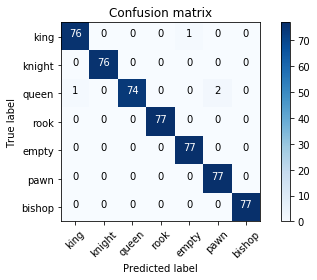

In [12]:
def classifyRandForest(X,Y, x,y):
    param_grid = {'n_estimators': range(100,200,10),
              'max_depth': range(14,17),}
    classifier = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
    classifier.fit(X, Y)
    plot_confusion_matrix(confusion_matrix(y, classifier.best_estimator_.predict(x)),y.unique())
    print(classifier.best_score_)
    print(classifier.best_estimator_.score(x, y))
    return classifier.best_estimator_
clf_figures = classifyRandForest(chess_features_train_pca50,chess_labels_train.type,
                   chess_features_test_pca50,chess_labels_test.type)
clf_figures

In [14]:
joblib.dump(clf_figures,"Rforest_Figure_recognizer.joblib")

['Rforest_Figure_recognizer.joblib']

Confusion matrix
[[135   0   1   0   0   2]
 [  3 126   0   2   3   3]
 [  0   3 131   1   1   2]
 [  2   0   0 134   0   2]
 [  0   1   1   3 133   0]
 [  1   1   2   0   0 134]]
0.9177403369672944
0.9588875453446191


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[600, 500], learning_rate='invscaling',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

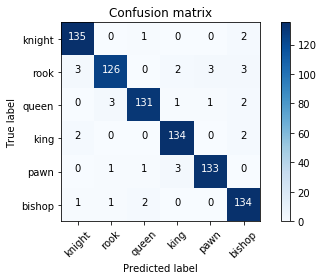

In [22]:
#18
def classifyMLP(X,Y,x,y):
    param_grid = {
                'learning_rate_init': [0.001],
              'hidden_layer_sizes': [[600,500]], }
    classifier = GridSearchCV(MLPClassifier(solver='lbfgs', learning_rate='invscaling'), param_grid, cv=5)
    classifier.fit(X, Y)
    plot_confusion_matrix(confusion_matrix(y, classifier.best_estimator_.predict(x)),y.unique())
    print(classifier.best_score_)
    print(classifier.best_estimator_.score(x, y))
    return classifier.best_estimator_
clf_fig = classifyMLP(chess_features_train_pca50,chess_labels_train.type,
                   chess_features_test_pca50,chess_labels_test.type)
clf_fig

In [19]:
joblib.dump(clf_fig,"MLP_Figure_recognizer.joblib")

['MLP_Figure_recognizer.joblib']

In [14]:
chess_features = chess_data_noEmpty.drop(['type','color'],axis=1)
chess_features/=255

chess_labels = chess_data_noEmpty.iloc[:,-2:]

chess_features_train,chess_features_test,chess_labels_train,chess_labels_test = train_test_split(
    chess_features, chess_labels, train_size=0.55, test_size=0.45, stratify=chess_labels.type,random_state=4321)

pca = PCA(n_components=250,whiten=True).fit(chess_features_train)
chess_features_train_pca250 = pca.transform(chess_features_train)
chess_features_test_pca250 = pca.transform(chess_features_test)

pca = PCA(n_components=200,whiten=True).fit(chess_features_train)
chess_features_train_pca200 = pca.transform(chess_features_train)
chess_features_test_pca200 = pca.transform(chess_features_test)

pca = PCA(n_components=150,whiten=True).fit(chess_features_train)
chess_features_train_pca150 = pca.transform(chess_features_train)
chess_features_test_pca150 = pca.transform(chess_features_test)

pca = PCA(n_components=100,whiten=True).fit(chess_features_train)
chess_features_train_pca100 = pca.transform(chess_features_train)
chess_features_test_pca100 = pca.transform(chess_features_test)
joblib.dump(pca,"colpca100.joblib")
pca = PCA(n_components=50,whiten=True).fit(chess_features_train)
chess_features_train_pca50 = pca.transform(chess_features_train)
chess_features_test_pca50 = pca.transform(chess_features_test)
joblib.dump(pca,"colpca50.joblib")

['colpca50.joblib']

Confusion matrix
[[408   0]
 [  0 419]]
0.9990089197224975
1.0


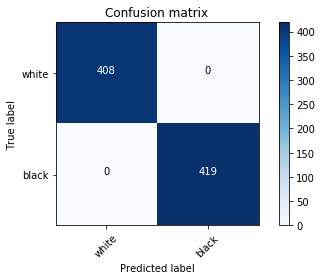

In [23]:
clf_color = classifyMLP(chess_features_train_pca50,chess_labels_train.color,
                   chess_features_test_pca50,chess_labels_test.color)

In [24]:
joblib.dump(clf_color,"MLP_Color_recognizer.joblib")

['MLP_Color_recognizer.joblib']

Confusion matrix
[[254   2]
 [  1 262]]
0.990521327014218
0.9942196531791907


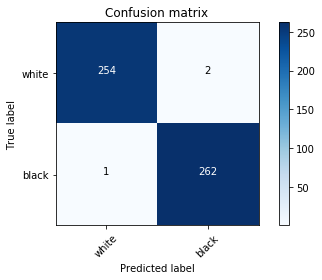

In [25]:
clf_color = classifyRandForest(chess_features_train_pca50,chess_labels_train.color,
                   chess_features_test_pca50,chess_labels_test.color)

In [25]:
joblib.dump(clf_color,"RForest_Color_recognizer.joblib")

['RForest_Color_recognizer.joblib']

Confusion matrix
[[408   0]
 [  0 419]]
0.998017839444995
1.0


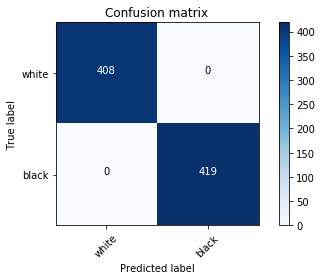

In [15]:
clf_color = classifyLogReg(chess_features_train_pca50,chess_labels_train.color,
                   chess_features_test_pca50,chess_labels_test.color)

Here logistic regression does well because the data is easily line separatable.

In [26]:
joblib.dump(clf_color,"LogReg_Color_recognizer.joblib")

['LogReg_Color_recognizer.joblib']